# Demo: Voltage-Controlled Resistor (VCR)

This notebook demonstrates the Voltage-Controlled Resistor (VCR) component.

**VCR Equation:**
```
R = R₀ + k × V_ctrl
```

**Demo Circuit: Voltage Divider with VCR**
```
    Vs (10V)
      │
     [R1]  (fixed 1kΩ)
      │
      ├──── V_out (measured)
      │
    [VCR]  (R = R0 + k*V_ctrl)
      │
     GND
```

Output voltage: `V_out = Vs × R_vcr / (R1 + R_vcr)`

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from pyvibrate.timedomain import Network, R, VSource, VCR

## Circuit Parameters

In [2]:
# Supply
Vs = 10.0  # Volts

# Fixed resistor
R1 = 1000.0  # 1 kΩ

# VCR parameters: R = R0 + k * V_ctrl
R0 = 500.0   # Base resistance: 500 Ω
k = 200.0    # Sensitivity: 200 Ω/V

print(f"Supply voltage: Vs = {Vs} V")
print(f"Fixed resistor: R1 = {R1} Ω")
print(f"")
print(f"VCR: R = {R0} + {k} × V_ctrl")
print(f"  V_ctrl = 0V  →  R = {R0} Ω")
print(f"  V_ctrl = 1V  →  R = {R0 + k*1} Ω")
print(f"  V_ctrl = 2V  →  R = {R0 + k*2} Ω")

Supply voltage: Vs = 10.0 V
Fixed resistor: R1 = 1000.0 Ω

VCR: R = 500.0 + 200.0 × V_ctrl
  V_ctrl = 0V  →  R = 500.0 Ω
  V_ctrl = 1V  →  R = 700.0 Ω
  V_ctrl = 2V  →  R = 900.0 Ω


## Build the Circuit

In [3]:
net = Network()

# Nodes
net, n_supply = net.node("supply")
net, n_out = net.node("out")      # Output node (middle of divider)
net, n_ctrl = net.node("ctrl")    # Control voltage node

# Voltage source
net, vs = VSource(net, n_supply, net.gnd, name="vs", value=Vs)

# Fixed resistor R1
net, r1 = R(net, n_supply, n_out, name="R1", value=R1)

# VCR: between output and ground, controlled by n_ctrl
net, vcr = VCR(net, n_out, net.gnd, n_ctrl, net.gnd,
               name="VCR1", r0=R0, k=k)

# Control voltage source
net, v_ctrl = VSource(net, n_ctrl, net.gnd, name="v_ctrl", value=0.0)

print(f"Circuit: {net.num_nodes} nodes, {len(net.components)} components")

Circuit: 3 nodes, 4 components


## Sweep Control Voltage

In [4]:
dt = 1e-6
sim = net.compile(dt=dt)

# Sweep V_ctrl from -2V to +4V
v_ctrl_values = np.linspace(-2.0, 4.0, 61)

v_out_measured = []
r_vcr_values = []
v_out_theoretical = []

for v_ctrl_val in v_ctrl_values:
    state = sim.init({})
    # Run 2 steps (VCR has 1-step delay)
    state = sim.step({}, state, {"v_ctrl": v_ctrl_val})
    state = sim.step({}, state, {"v_ctrl": v_ctrl_val})
    
    v_out_measured.append(float(sim.v(state, n_out)))
    
    r_vcr = R0 + k * v_ctrl_val
    r_vcr_values.append(r_vcr)
    v_out_theoretical.append(Vs * r_vcr / (R1 + r_vcr) if r_vcr > 0 else np.nan)

v_out_measured = np.array(v_out_measured)
r_vcr_values = np.array(r_vcr_values)
v_out_theoretical = np.array(v_out_theoretical)

print(f"Sweep complete: {len(v_ctrl_values)} points")

Sweep complete: 61 points


## Results

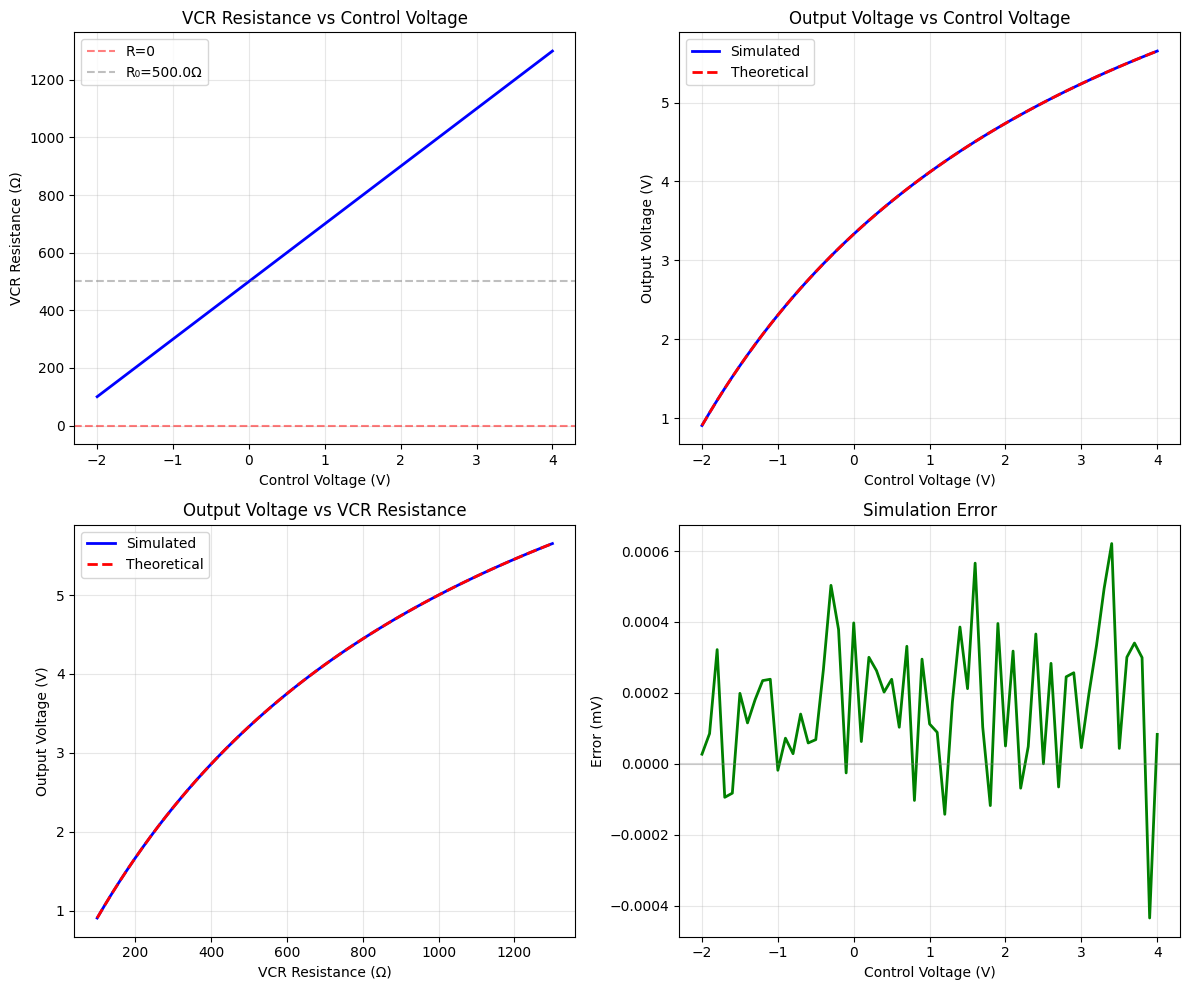


Key values:
  V_ctrl = 0V → R = 500Ω → V_out = 3.333V
  V_ctrl = 1V → R = 700Ω → V_out = 4.118V
  V_ctrl = 2V → R = 900Ω → V_out = 4.737V
  V_ctrl = 3V → R = 1100Ω → V_out = 5.238V


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: VCR resistance vs control voltage
ax1 = axes[0, 0]
ax1.plot(v_ctrl_values, r_vcr_values, 'b-', linewidth=2)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='R=0')
ax1.axhline(y=R0, color='gray', linestyle='--', alpha=0.5, label=f'R₀={R0}Ω')
ax1.set_xlabel('Control Voltage (V)')
ax1.set_ylabel('VCR Resistance (Ω)')
ax1.set_title('VCR Resistance vs Control Voltage')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Output voltage vs control voltage
ax2 = axes[0, 1]
ax2.plot(v_ctrl_values, v_out_measured, 'b-', linewidth=2, label='Simulated')
ax2.plot(v_ctrl_values, v_out_theoretical, 'r--', linewidth=2, label='Theoretical')
ax2.set_xlabel('Control Voltage (V)')
ax2.set_ylabel('Output Voltage (V)')
ax2.set_title('Output Voltage vs Control Voltage')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Output voltage vs VCR resistance
ax3 = axes[1, 0]
valid = r_vcr_values > 0
ax3.plot(r_vcr_values[valid], v_out_measured[valid], 'b-', linewidth=2, label='Simulated')
ax3.plot(r_vcr_values[valid], v_out_theoretical[valid], 'r--', linewidth=2, label='Theoretical')
ax3.set_xlabel('VCR Resistance (Ω)')
ax3.set_ylabel('Output Voltage (V)')
ax3.set_title('Output Voltage vs VCR Resistance')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Error
ax4 = axes[1, 1]
error_mv = (v_out_measured - v_out_theoretical) * 1000
ax4.plot(v_ctrl_values[valid], error_mv[valid], 'g-', linewidth=2)
ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax4.set_xlabel('Control Voltage (V)')
ax4.set_ylabel('Error (mV)')
ax4.set_title('Simulation Error')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey values:")
for v_ctrl_val in [0.0, 1.0, 2.0, 3.0]:
    idx = np.argmin(np.abs(v_ctrl_values - v_ctrl_val))
    r = r_vcr_values[idx]
    v_sim = v_out_measured[idx]
    print(f"  V_ctrl = {v_ctrl_val:.0f}V → R = {r:.0f}Ω → V_out = {v_sim:.3f}V")

## Frequency Mixing: AC Source × AC Control

Now let's use an AC supply voltage and AC control signal at different frequencies.
The VCR acts as a **multiplier** - the output contains sum and difference frequencies.

```
V_out ∝ Vs × R_vcr / (R1 + R_vcr)
      ∝ Vs × (R0 + k × V_ctrl)
      ∝ Vs × V_ctrl  (the multiplicative term)
```

With Vs = sin(2πf_s·t) and V_ctrl = sin(2πf_c·t), the product contains:
- f_s + f_c (sum frequency)
- f_s - f_c (difference frequency)

In [6]:
# Frequencies
f_source = 5000   # 5 kHz carrier (supply voltage)
f_ctrl = 500      # 500 Hz modulation (control voltage)

# Amplitudes
Vs_dc = 5.0       # DC offset for supply (keeps it positive)
Vs_ac = 5.0       # AC amplitude for supply
v_ctrl_dc = 1.5   # DC offset for control (keeps R positive)  
v_ctrl_ac = 1.0   # AC amplitude for control

# Time parameters - higher resolution for better FFT
dt = 0.2e-6       # 0.2 µs (5x finer than before)
t_end = 30e-3     # 30 ms (3x longer - 15 cycles of 500 Hz)
n_steps = int(t_end / dt)

sim = net.compile(dt=dt)

times = []
v_source_signal = []
v_ctrl_signal = []
v_out_signal = []

state = sim.init({})

for step in range(n_steps):
    t = step * dt
    
    # AC supply voltage (5 kHz carrier)
    v_source = Vs_dc + Vs_ac * np.sin(2 * np.pi * f_source * t)
    
    # AC control voltage (500 Hz modulation)
    v_ctrl_val = v_ctrl_dc + v_ctrl_ac * np.sin(2 * np.pi * f_ctrl * t)
    
    controls = {"vs": v_source, "v_ctrl": v_ctrl_val}
    state = sim.step({}, state, controls)
    
    times.append(float(state.time))
    v_source_signal.append(v_source)
    v_ctrl_signal.append(v_ctrl_val)
    v_out_signal.append(float(sim.v(state, n_out)))

times = np.array(times)
v_source_signal = np.array(v_source_signal)
v_ctrl_signal = np.array(v_ctrl_signal)
v_out_signal = np.array(v_out_signal)

# FFT frequency resolution = 1/t_end
freq_resolution = 1.0 / t_end

print(f"Simulation: {n_steps} steps, {t_end*1e3:.0f} ms")
print(f"Source: {f_source} Hz carrier")
print(f"Control: {f_ctrl} Hz modulation")
print(f"Expected mixing products: {f_source + f_ctrl} Hz, {f_source - f_ctrl} Hz")
print(f"FFT frequency resolution: {freq_resolution:.1f} Hz")

Simulation: 150000 steps, 30 ms
Source: 5000 Hz carrier
Control: 500 Hz modulation
Expected mixing products: 5500 Hz, 4500 Hz
FFT frequency resolution: 33.3 Hz


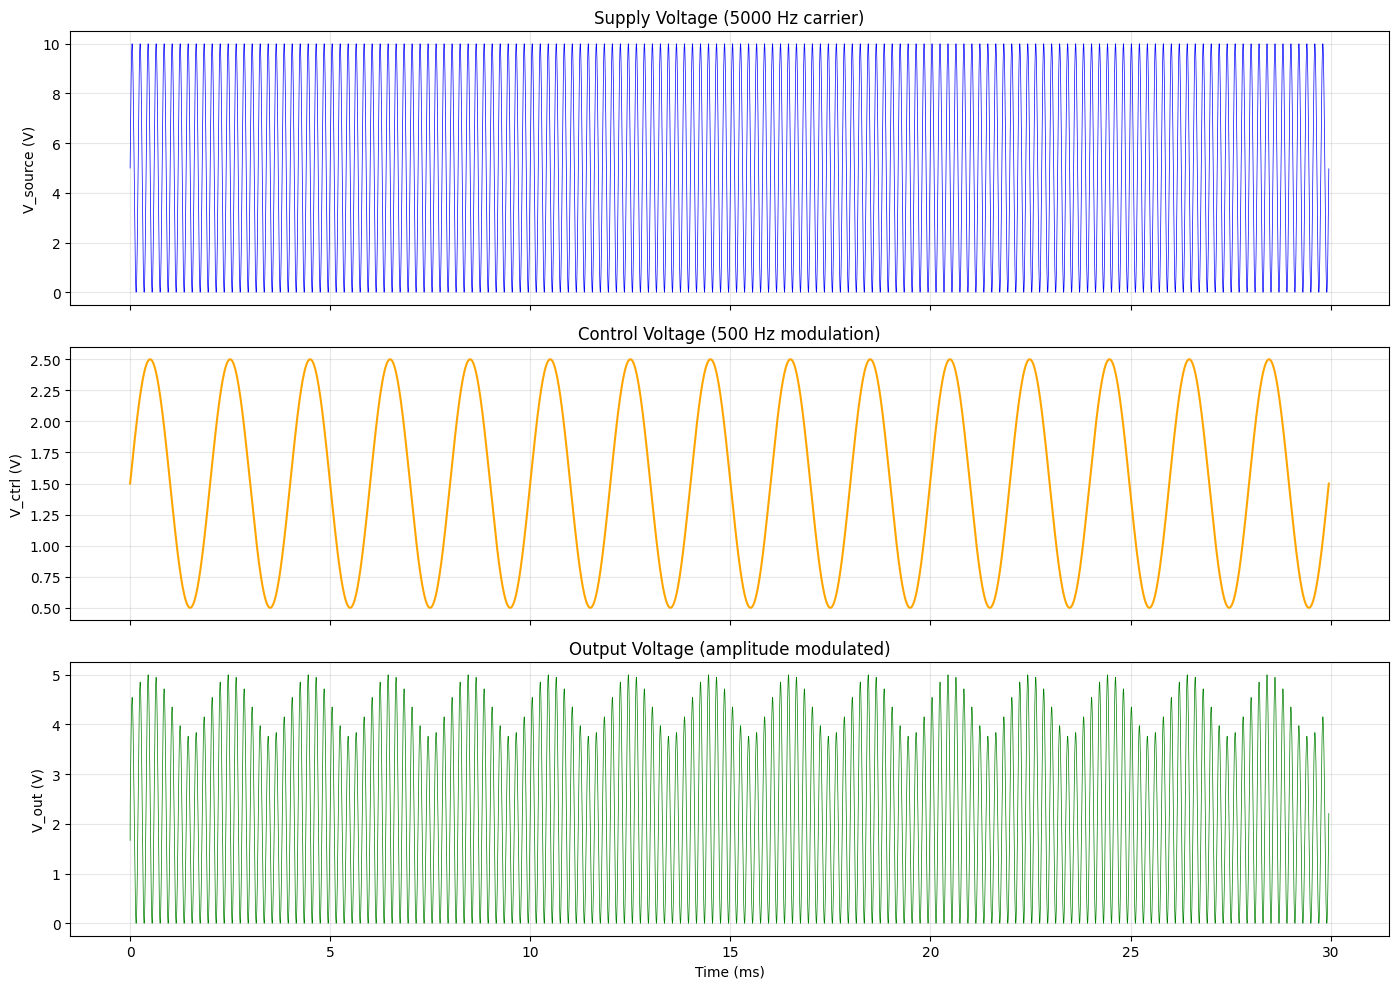

Output range: [0.000, 4.994] V


In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
times_ms = times * 1e3

# Plot 1: Source voltage (5 kHz carrier)
ax1 = axes[0]
ax1.plot(times_ms, v_source_signal, 'blue', linewidth=0.5)
ax1.set_ylabel('V_source (V)')
ax1.set_title(f'Supply Voltage ({f_source} Hz carrier)')
ax1.grid(True, alpha=0.3)

# Plot 2: Control voltage (500 Hz modulation)
ax2 = axes[1]
ax2.plot(times_ms, v_ctrl_signal, 'orange', linewidth=1.5)
ax2.set_ylabel('V_ctrl (V)')
ax2.set_title(f'Control Voltage ({f_ctrl} Hz modulation)')
ax2.grid(True, alpha=0.3)

# Plot 3: Output voltage (shows amplitude modulation)
ax3 = axes[2]
ax3.plot(times_ms, v_out_signal, 'green', linewidth=0.5)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('V_out (V)')
ax3.set_title('Output Voltage (amplitude modulated)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Output range: [{v_out_signal.min():.3f}, {v_out_signal.max():.3f}] V")

## Spectrum Analysis

Let's look at the frequency content to see the mixing products.

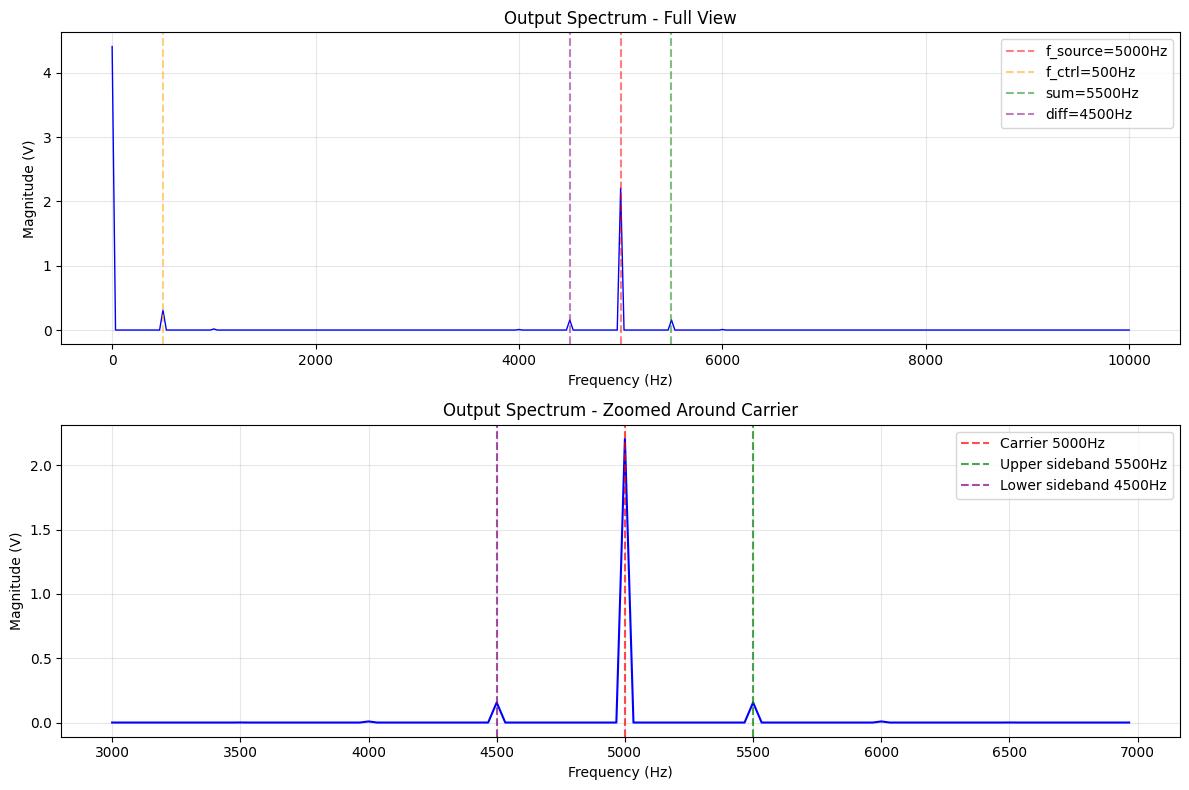


Significant frequency components:
  500 Hz: 0.312 V
  4500 Hz: 0.156 V
  5000 Hz: 2.205 V
  5500 Hz: 0.156 V


In [8]:
from scipy.fft import fft, fftfreq

# Compute FFT of output
N = len(v_out_signal)
yf = fft(v_out_signal)
xf = fftfreq(N, dt)

# Only positive frequencies
pos_mask = xf >= 0
xf_pos = xf[pos_mask]
yf_mag = 2.0/N * np.abs(yf[pos_mask])

# Plot spectrum
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Full spectrum up to 10 kHz
ax1 = axes[0]
freq_mask = xf_pos <= 10000
ax1.plot(xf_pos[freq_mask], yf_mag[freq_mask], 'b-', linewidth=1)
ax1.axvline(x=f_source, color='red', linestyle='--', alpha=0.5, label=f'f_source={f_source}Hz')
ax1.axvline(x=f_ctrl, color='orange', linestyle='--', alpha=0.5, label=f'f_ctrl={f_ctrl}Hz')
ax1.axvline(x=f_source+f_ctrl, color='green', linestyle='--', alpha=0.5, label=f'sum={f_source+f_ctrl}Hz')
ax1.axvline(x=f_source-f_ctrl, color='purple', linestyle='--', alpha=0.5, label=f'diff={f_source-f_ctrl}Hz')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (V)')
ax1.set_title('Output Spectrum - Full View')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Zoomed around carrier frequency
ax2 = axes[1]
zoom_mask = (xf_pos >= 3000) & (xf_pos <= 7000)
ax2.plot(xf_pos[zoom_mask], yf_mag[zoom_mask], 'b-', linewidth=1.5)
ax2.axvline(x=f_source, color='red', linestyle='--', alpha=0.7, label=f'Carrier {f_source}Hz')
ax2.axvline(x=f_source+f_ctrl, color='green', linestyle='--', alpha=0.7, label=f'Upper sideband {f_source+f_ctrl}Hz')
ax2.axvline(x=f_source-f_ctrl, color='purple', linestyle='--', alpha=0.7, label=f'Lower sideband {f_source-f_ctrl}Hz')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (V)')
ax2.set_title('Output Spectrum - Zoomed Around Carrier')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find and print peak frequencies
peak_indices = np.where(yf_mag > 0.1)[0]
print("\nSignificant frequency components:")
for idx in peak_indices:
    if xf_pos[idx] > 0:
        print(f"  {xf_pos[idx]:.0f} Hz: {yf_mag[idx]:.3f} V")

## Summary

The VCR provides linear resistance control: **R = R₀ + k × V_ctrl**

**Part 1: Static Characteristic**
- Swept control voltage, confirmed V_out matches voltage divider equation

**Part 2: Frequency Mixing**
- 5 kHz carrier (supply) × 500 Hz modulation (control)
- Output shows sidebands at 4500 Hz and 5500 Hz
- Classic AM modulation / mixer behavior

**Applications:**
- Amplitude modulation (AM)
- Frequency mixers
- Voltage-controlled attenuators
- Automatic gain control (AGC)